# <a href="https://miptstats.github.io/courses/ad_fivt.html">Введение в анализ данных</a>
## Домашнее задание 6. Основы обработки текстов


**Правила, <font color="red">прочитайте внимательно</font>:**

* Выполненную работу нужно отправить телеграм-боту `@miptstats_ds24_bot`. Для начала работы с ботом каждый раз отправляйте `/start`. **Работы, присланные иным способом, не принимаются.**
* Дедлайн см. в боте. После дедлайна работы не принимаются кроме случаев наличия уважительной причины.
* Прислать нужно **ноутбук в формате `ipynb`**.
* Следите за размером файлов. **Бот не может принимать файлы весом более 20 Мб.** Если файл получается больше, заранее разделите его на несколько.
* Выполнять задание необходимо полностью самостоятельно. **При обнаружении списывания все участники списывания будут сдавать устный зачет.**
* Решения, размещенные на каких-либо интернет-ресурсах, не принимаются. Кроме того, публикация решения в открытом доступе может быть приравнена к предоставлении возможности списать.
* Для выполнения задания используйте этот ноутбук в качестве основы, ничего не удаляя из него. Можно добавлять необходимое количество ячеек.
* Комментарии к решению пишите в markdown-ячейках.
* Выполнение задания (ход решения, выводы и пр.) должно быть осуществлено на русском языке.
* Если код будет не понятен проверяющему, оценка может быть снижена.
* Никакой код из данного задания при проверке запускаться не будет. *Если код студента не выполнен, недописан и т.д., то он не оценивается.*


**Баллы за задание:**

* Задача 1 &mdash; 100 баллов
* Задача 2 &mdash; 50 баллов

Баллы учитываются в <b><font color="green">факультативной части</font></b> курса и не влияют на оценку по основной части.

In [ ]:
# Bot check

# HW_ID: fpmi_ad6
# Бот проверит этот ID и предупредит, если случайно сдать что-то не то.

# Status: final
# Перед отправкой в финальном решении удали "not" в строчке выше.
# Так бот проверит, что ты отправляешь финальную версию, а не промежуточную.
# Никакие значения в этой ячейке не влияют на факт сдачи работы.

In [1]:
import time
import numpy as np
import pandas as pd
from tqdm import tqdm
from string import punctuation
import matplotlib.pyplot as plt
from collections import Counter, OrderedDict
from IPython.display import clear_output

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import torchtext
from torchtext.data.utils import get_tokenizer

import seaborn as sns

sns.set(palette="Set2")
sns.set_style("whitegrid")

import nltk

nltk.download("stopwords")

device = (
    "mps"
    if torch.backends.mps.is_available()
    else "cuda" if torch.cuda.is_available() else "cpu"
)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Перед выполнением задания обязательно посмотрите <a href="https://miptstats.github.io/courses/ad_fivt/lecture6.pdf" target="_blank">презентацию</a>, [ноутбук](https://miptstats.github.io/courses/ad_fivt/nlp_sem.html) по RNN и [ноутбук](https://miptstats.github.io/courses/ad_fivt/nlp_sem_llama.html) по генерации текста.

---
### Задача 1. Предсказание заработной платы


В этой задаче вам предлагается решить задачу регрессии &mdash; по текстовому описанию вакансии определить заработную плату. Для решения такой задачи можно применять различные методы, в том числе и те, которые были рассмотрены на лекции.
Мы будем решать эту задачу с помощью рекуррентной нейронной сети.

Датасет `salary_dataset.csv` лежит по <a target="_blank" href="https://drive.google.com/file/d/1Q3lCw_8Uad_OzHCjvLeYRvamXR74UPbW/view?usp=sharing">ссылке</a> (312.3 MB).

Если вы работаете локально:

> Просто скачайте этот файл и укажите пути к ним ниже.


Если вы используете <a target="_blank" href="https://colab.research.google.com/">Colab</a>:
> **Скачивать файл не обязательно**. Просто подключитесь к Google Drive:
>
> ```
> from google.colab import drive
> drive.mount('/content/drive/')
> ```
>
> Перейдите по ссылке файла и добавьте shortcut на него в ваш собственный диск:
> 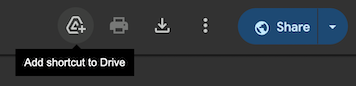

In [4]:
from google.colab import drive
drive.mount('/drive')
path = "/drive/MyDrive/DS/Nlp_task"

!mkdir data/content
!cp -a /$path/. data/content/

Mounted at /drive


Скачаем данные для обучения и тестирования:

In [5]:
dataset = pd.read_csv("data/content/salary_dataset.csv")
dataset.head()

,FullDescription,SalaryNormalized
0,This is an exciting opportunity for a Recruite...,55000
1,Our client is looking for a .net web developer...,27500
2,"MS SQL Database Administrator Helsinki, Finla...",72098
3,ACADEMIC APPOINTMENTS A large secondary school...,32400
4,Head of User Experience c. ****k / London A H...,67500


Каждая строка содержит полное описание вакансии и соответствующую зарплату. При этом описания могут быть довольно длинными, например:

In [ ]:
dataset.iloc[0]["FullDescription"]

'This is an exciting opportunity for a Recruiter to join a rapidly growing online retailer. You will be responsible for developing and executing recruiting plans across the company. Your key accountabilities will include creating job descriptions, working closely with hiring managers, reducing recruitment costs, coordinating and implementing university recruitment initiatives and networking with industry contacts. You should be of graduate calibre with a track record in recruitment ideally gained in a fast moving start up environment. Experience of working in an online company would be a distinct advantage. Our client is an online retailer operating in the UK and in Continental Europe. This job was originally posted as www.totaljobs.com/JobSeeking/RecruitmentManager_job****'

Для данной задачи нам не будут нужны служебные части речи и знаки пунктуации. Зададим токенизатор, списки стоп-слов и пунктуации.

In [ ]:
# Зададим токенизаторы
tokenizer = get_tokenizer("spacy", language="en_core_web_sm")
stop_words = nltk.corpus.stopwords.words("english")  # стоп-слова
punc = list(punctuation)  # пунктуация

Подготовьте словарь, оставив в нем только наиболее часто встречающиеся токены. Не забудьте предварительно убрать из предложений знаки пунктуации и стоп-слова.

*Можно использовать код с [семинара](https://miptstats.github.io/courses/ad_fivt/nlp_sem.html).*

In [ ]:
# зададим счетчики
counter = Counter()

# посчитаем количество вхождений каждого токена
for text in dataset["FullDescription"]:
    counter.update(
        token
        for token in tokenizer(text)
        if token not in stop_words and token not in punc
    )

ordered_dict = OrderedDict(counter)
MAX_VOCAB_SIZE = 25000  # ограничение на словарь
ordered_dict = OrderedDict(counter.most_common(MAX_VOCAB_SIZE))

Этот упорядоченный словарь хранит слово и его встречаемость. Можно посмотреть на самые частые слова в датасете:

In [ ]:
list(ordered_dict.items())[:10]

[(' ', 666725),
 ('experience', 269289),
 ('The', 258645),
 ('role', 211475),
 ('work', 207318),
 ('team', 194087),
 ('This', 180149),
 ('within', 175173),
 ('You', 173743),
 ('skills', 162215)]

Теперь изменим словарь, добавив в него специальные токены, которые необходимы для подготовки данных к обучению:

In [ ]:
# зададим словарь
vocab = torchtext.vocab.vocab(ordered_dict)

unk_token = "<unk>"
pad_token = "<pad>"


def add_special_tokens(vocab):
    """Функция для добавления специальных токенов в словарь."""
    for special_token in [unk_token, pad_token]:
        vocab.append_token(special_token)
    vocab.set_default_index(vocab[unk_token])
    UNK_IDX = vocab[unk_token]
    PAD_IDX = vocab[pad_token]
    return vocab, UNK_IDX, PAD_IDX


vocab, UNK_IDX_EN, PAD_IDX_EN = add_special_tokens(vocab)
num_tokens = len(vocab)

Подготовим класс датасета:

In [ ]:
class SalaryPredictionDataset(Dataset):
    """Класс датасета для предсказания зарплаты"""

    def __init__(self, texts, target):
        """
        Параметры.
        1) texts (list) — корпус токенизированных текстов, на котором будет
                          происходить обучение
        2) labels (list) — истинные метки текстов
        """
        self.texts = texts
        self.target = target

    def __len__(self):
        return len(self.target)

    def __getitem__(self, idx):
        return self.texts[idx], self.target[idx]

Допишите функцию для дополнения текста до максимальной длины в батче. Снова воспользуйтесь кодом с [семинара](https://miptstats.github.io/courses/ad_fivt/nlp_sem.html).

*Обратите внимание, что теперь вместо целочисленных меток мы используем вещественные таргеты. Если не поменять код с семинара, то вы можете решать неправильную задачу.*

In [ ]:
def pad_collate(batch):
    """
    Формирует тензоры из токенизированных текстов и таргетов, а также
    дополняет последовательности токенов до макс. длины в батче с UNK_IDX

    Вход:
    * batch — батч с текстами и таргетами

    Возвращает:
    * texts_tensors - список тензоров текстов из батча, дополненных паддингом
    * target - список соответствующих меток батча
    """
    texts, target = zip(*batch)

    texts_tensors = [torch.LongTensor(t) for t in texts]
    target = torch.FloatTensor(target)

    texts_tensors = pad_sequence(
        texts_tensors, padding_value=PAD_IDX_EN, batch_first=True
    )

    return texts_tensors, target

Токенизируем текст, а таргет переведем во `float`.

In [ ]:
tokens = [vocab(tokenizer(text)) for text in dataset["FullDescription"]]
target = [float(value) for value in dataset["SalaryNormalized"]]

Каждому из текстов в датасете сопоставляется последовательность токенов, причем везде разного размера:

In [ ]:
for i in range(3):
    print(f"Количество токенов в {i}-м тексте - {len(tokens[i])}:\n  ", end="")
    for token in tokens[i][:10]:
        print(token, end=", ")
    print("...\nТаргет:", target[i], "\n")

Количество токенов в 0-м тексте - 122:
  6, 25000, 25000, 141, 18, 25000, 25000, 3605, 25000, 35, ...
Таргет: 55000.0 

Количество токенов в 1-м тексте - 73:
  67, 12, 25000, 14, 25000, 25000, 4674, 393, 871, 25000, ...
Таргет: 27500.0 

Количество токенов в 2-м тексте - 309:
  573, 186, 1517, 658, 0, 24450, 25000, 15730, 13311, 87, ...
Таргет: 72098.0 



При решении задач регрессии с помощью нейросетей удобнее всего бывает перевести предсказываемые значения в небольшой диапазон, например, от 0 до 1. Это нужно, чтобы повысить численную стабильность обучения &mdash; не нагружать модель большими значениями таргетов. В нашей задаче это важно, ведь зарплата может иметь большой разброс и принимать большие значения.

Чтобы сделать это, воспользуемся преобразованием `MinMaxScaler` из библиотеки `sklearn`, которое мы рассматривали в [задаче 3 задания 3](https://miptstats.github.io/courses/ad_fivt/task3.html#%D0%97%D0%B0%D0%B4%D0%B0%D1%87%D0%B0-3.).
Таким образом, мы получим значения, удобные для использования при обучении.

In [ ]:
train_tokens, valid_tokens, train_target, valid_target = train_test_split(
    tokens, target
)

scaler = MinMaxScaler()
train_target_std = scaler.fit_transform(np.array(train_target).reshape(-1, 1))
valid_target_std = scaler.transform(np.array(valid_target).reshape(-1, 1))

train_data = SalaryPredictionDataset(train_tokens, train_target_std)
valid_data = SalaryPredictionDataset(valid_tokens, valid_target_std)
len(train_data), len(valid_data)

(150000, 50000)

Посмотрим на отмасштабированные значения зарплаты:

In [ ]:
print("Преобразованные таргеты:")
for t in train_data[:3][1]:
    print(round(t.item(), 4), end=", ")
print("...")

Преобразованные таргеты:
0.141, 0.0051, 0.0367, ...


Сформируйте даталоадеры для обучения и валидации.

In [ ]:
BATCH_SIZE = 64  # размер батча

# сформируем даталоадеры
train_loader = DataLoader(
    train_data, batch_size=BATCH_SIZE, shuffle=True, collate_fn=pad_collate
)

valid_loader = DataLoader(
    valid_data, batch_size=BATCH_SIZE, shuffle=False, collate_fn=pad_collate
)

Наконец, можем подготовить модель. Будем использовать рекуррентную архитектуру, подобную той, что была на [семинаре](https://miptstats.github.io/courses/ad_fivt/nlp_sem.ipynb).
Отличие состоит в том, что теперь мы предсказываем не метку класса, а вещественный таргет. Подумайте, какую часть сети нужно изменить, чтобы адаптировать ее к нашей задаче.

In [ ]:
class SimpleRNNRegressor(nn.Module):
    """ Модель для регрессии на основе LSTM"""

    def __init__(
        self,
        num_tokens,
        emb_size=512,
        rnn_num_units=64,
        output_dim=1,
        layers=1
    ):
        """
        1) num_tokens — общее количество токенов,
        2) emb_size — размер эмбеддингового пространства,
        3) rnn_num_units - размер пространства скрытых представлений в rnn,
        4) output_dim - размерность выхода-предсказания.
        """
        super(self.__class__, self).__init__()

        self.emb = nn.Embedding(num_tokens, emb_size, padding_idx=PAD_IDX_EN)
        self.rnn = nn.LSTM(input_size=emb_size, hidden_size=rnn_num_units, batch_first=True, num_layers=layers)
        self.classifier = nn.Linear(rnn_num_units, output_dim)

    def forward(self, x):
        """
        * x — общее количество токенов.

        Возвращает:
        * predictions - предсказания модели.
        """

        # Получим эмбеддинги для входов
        # (batch_size, max_pad_len, emb_size)
        emb = self.emb(x)

        # Прогоним через RNN-сеть и получим скрытое состояние,
        # в котором хранится нужная информация о последовательности
        # (batch_size, rnn_num_units)
        _, (h_state, _) = self.rnn(emb)

        # Прогоним через полносвязный слой и получим логиты для каждого токена
        # (batch_size, num_tokens)
        predictions = self.classifier(h_state.squeeze(0))
        return predictions

Так как теперь решаем задачу регрессии, вместо точности модели будем измерять среднеквадратичную ошибку:

In [ ]:
def mse(preds, y):
    """
    Возвращает среднеквадратичную ошибку модели.

    Параметры.
    1) preds — предсказания модели,
    2) y — истинные значения таргета.
    """

    return F.mse_loss(preds, y, reduction="mean")

Допишите функции для обучения и валидации. Они почти не будут отличаться от тех, что были на [семинаре](https://miptstats.github.io/courses/ad_fivt/nlp_sem.html).

In [ ]:
def train(model, iterator, optimizer, criterion, train_loss_history):
    """
    Функция для обучения модели на обучающем датасете и подсчёта
    её ошибки.

    Параметры.
    1) model — модель,
    2) iterator — итератор обучающего датасета,
    3) optimizer — класс метода оптимизации,
    4) criterion — функция потерь.
    """

    epoch_loss = 0
    epoch_mse = 0
    model.train()

    # Проход по всему датасету
    for batch_id, batch in enumerate(iterator):
        # Обучение на 1 батче, подсчет метрики
        optimizer.zero_grad()

        texts, labels = batch
        texts, labels = texts.to(device), labels.to(device)
        predictions = model(texts).squeeze(1)
        loss = criterion(predictions, labels)
        mse_ = mse(predictions, labels)

        # сделаем back-propagation для подсчёта градиентов
        loss.backward()
        # выполним шаг оптимизатора
        optimizer.step()
        # обновим метрики
        epoch_loss += loss.item()
        epoch_mse += mse_.item()
        train_loss_history.append(loss.item())

    return epoch_loss / len(iterator), epoch_mse / len(iterator)


def evaluate(model, iterator, criterion, val_loss_history=None):
    """
    Функция для применения модели на валидационном/тестовом датасете и подсчёта
    её точности.

    Параметры.
    1) model — модель,
    2) iterator — итератор датасета,
    3) criterion — функция потерь.
    """

    epoch_loss = 0
    epoch_mse = 0

    model.eval()

    with torch.no_grad(): # отключим подсчёт градиентов на валидации
        # Проход по всему датасету
        for batch_id, batch in enumerate(iterator):
            texts, labels = batch
            texts, labels = texts.to(device), labels.to(device)
            # получим предсказания
            predictions = model(texts).squeeze(1)
            # посчитаем метрики
            loss = criterion(predictions, labels)
            mse_ = mse(predictions, labels)
            # обновим метрики
            epoch_loss += loss.item()
            epoch_mse += mse_.item()
            if val_loss_history is not None:
                val_loss_history.append(loss.item())

    return epoch_loss / len(iterator), epoch_mse / len(iterator)


def epoch_time(start_time, end_time):
    """
    Функция для подсчёта времени работы одной эпохи.

    Параметры.
    1) start_time — время начала запуска,
    2) end_time — время завершения работы эпохи.
    """

    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

Теперь определим итоговую функцию для всего цикла обучения:

In [ ]:
def visualize_epoch(epoch, start_time, loss_history, mse_history):
    """
    Функция для визуализации 1 эпохи.

    Параметры.
    1) epoch — номер эпохи,
    2) start_time — время начала эпохи,
    3) loss_history - tuple истории лосса на train и test,
    4) mse_history - tuple истории MSE на train и test.
    """
    # Посчитаем время работы одной эпохи
    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    # Отобразим графики лоссов
    clear_output(True)
    plt.figure(figsize=(18, 6))

    train_loss_history, val_loss_history = loss_history
    plt.subplot(1, 3, 1)
    plt.plot(train_loss_history)
    plt.title("Train Loss")
    plt.xlabel("Номер батча")
    plt.subplot(1, 3, 2)
    plt.plot(val_loss_history, color="tab:orange")
    plt.title("Valid Loss")
    plt.xlabel("Номер батча")

    # Отрисуем значение MSE от эпохи
    train_mse_history, val_mse_history = mse_history
    plt.subplot(1, 3, 3)
    plt.plot(train_mse_history, label="Train")
    plt.plot(val_mse_history, label="Valid")
    plt.legend()
    plt.title("MSE")
    plt.xlabel("Номер эпохи")
    plt.show()

    print(
        f"Номер эпохи: {epoch+1:02} | Время обучения эпохи: {epoch_mins}m {epoch_secs}s"
    )


def training_loop(model_instance, n_epochs=10):
    """
    Функция для обучения нейронной сети.

    Параметры.
    1) model_instance — обучаемая модель,
    2) n_epochs — количество эпох.
    """

    best_valid_loss = float("inf")
    train_loss_history = []
    val_loss_history = []
    train_mse_history = []
    val_mse_history = []

    for epoch in range(n_epochs):
        start_time = time.time()
        # Обучим одну эпоху на обучающем датасете
        train_loss, train_mse = train(
            model_instance,
            train_loader,
            optimizer,
            criterion,
            train_loss_history,
        )
        train_mse_history.append(train_mse)

        # Оценим ошибку модели на тестовом датасете
        valid_loss, valid_mse = evaluate(
            model_instance, valid_loader, criterion, val_loss_history
        )
        val_mse_history.append(valid_mse)

        # Если значение функции потерь улучшилось, сохраним параметры модели
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model_instance.state_dict(), "model_checkpoint.pt")

        # Визуализируем результаты эпохи
        visualize_epoch(
            epoch,
            start_time,
            (train_loss_history, val_loss_history),
            (train_mse_history, val_mse_history),
        )

In [ ]:
# Задайте параметры сети
model1 = SimpleRNNRegressor(
    num_tokens=len(vocab),
    emb_size=256,
    rnn_num_units=8,
    output_dim=1,
    layers=1
).to(device)

# У нас задача регрессии, будем использовать MSELoss
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model1.parameters(), lr=0.005)
history = []

# Посмотрите на получившуюся модель
model1

SimpleRNNRegressor(
  (emb): Embedding(25002, 256, padding_idx=25001)
  (rnn): LSTM(256, 2, batch_first=True)
  (classifier): Linear(in_features=2, out_features=1, bias=True)
)

Обучите несколько моделей с различными гиперпараметрами (например, шаг обучения, размер словаря, архитектура) и сравните их качество на тестовой выборке.

*Не пугайтесь, если у вас не будет получаться хорошее качество на валидации: решаемая задача довольно сложная, а RNN &mdash; достаточно простая архитектура. Но постарайтесь, чтобы модель хотя бы не вырождалась в константу. Для этого следите за переобучением!*

*На 3 курсе вы сможете познакомиться с моделями, которые решают такую задачу гораздо лучше.*

###Обучим 1ую Модель:

In [ ]:
model1

SimpleRNNRegressor(
  (emb): Embedding(25002, 256, padding_idx=25001)
  (rnn): LSTM(256, 2, batch_first=True)
  (classifier): Linear(in_features=2, out_features=1, bias=True)
)

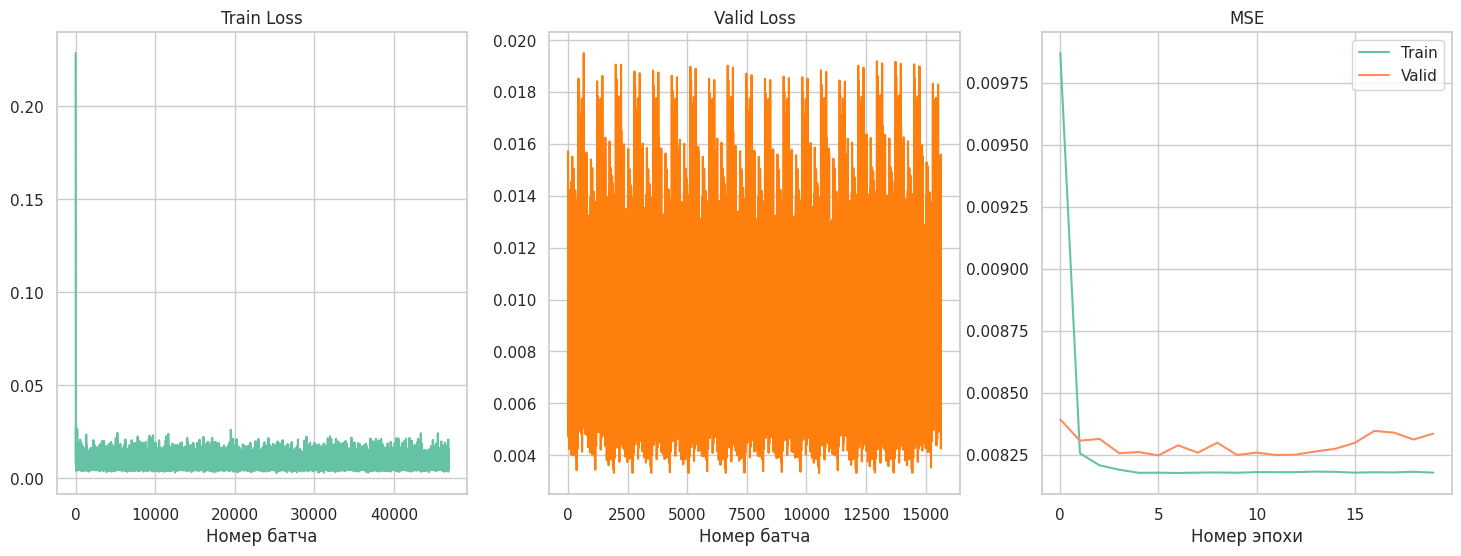

Номер эпохи: 20 | Время обучения эпохи: 0m 28s


In [ ]:
training_loop(model1, n_epochs=20)

После первой эпохи MSE на train сильно уменьшается, но на следующих эпохах он практически не изменяется. MSE на валидационной выборке вначале не сильно  ументшается, а после 12 эпохи опять возрастает. Такая архитектура нам не подходит. Возможно это связано с маленьким значением параметра layers. Попробуем в следующей модели его увеличить.

###2ая Модель

In [ ]:
model2 = SimpleRNNRegressor(
    num_tokens=len(vocab),
    emb_size=256,
    rnn_num_units=8,
    output_dim=1,
    layers=4
).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model2.parameters(), lr=0.005)
history = []

model2

SimpleRNNRegressor(
  (emb): Embedding(25002, 256, padding_idx=25001)
  (rnn): LSTM(256, 8, num_layers=4, batch_first=True)
  (classifier): Linear(in_features=8, out_features=1, bias=True)
)

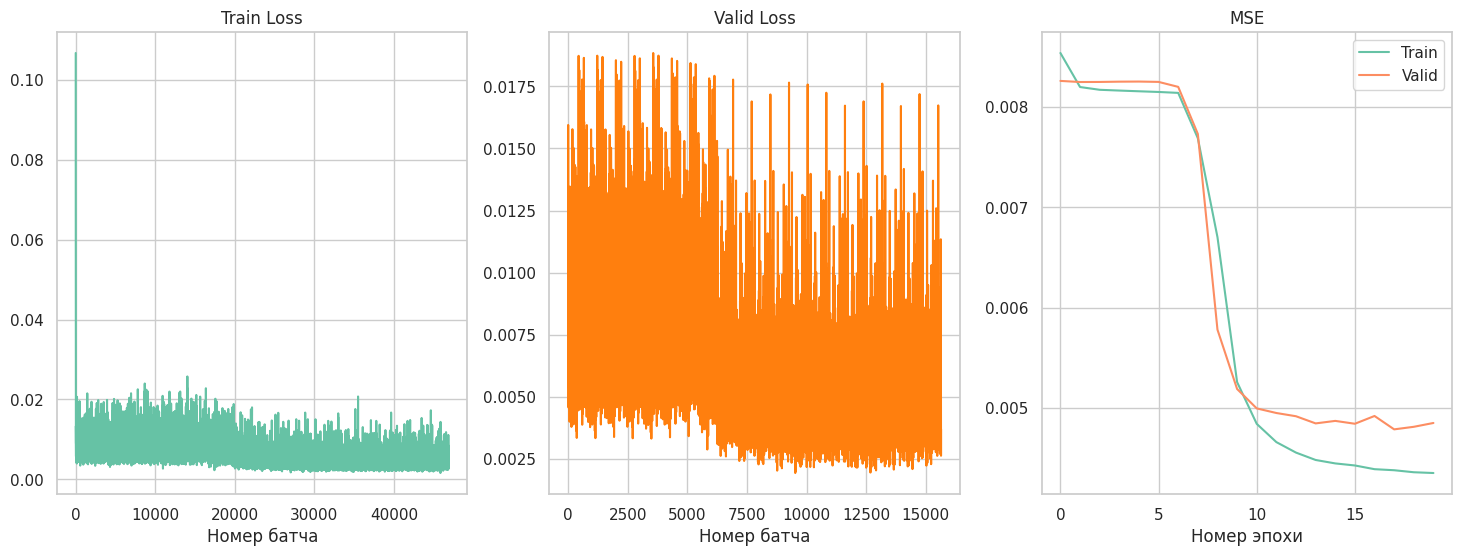

Номер эпохи: 20 | Время обучения эпохи: 0m 39s


In [ ]:
training_loop(model2, n_epochs=20)

Выведем MSE на последней эпохе:

In [ ]:
import warnings
warnings.filterwarnings('ignore')

print('MSE: ', evaluate(model2, valid_loader, criterion)[0])

MSE:  0.004848556422754703


При обучении лосс не вырождается в константу, при этом после 6ой эпохи резко уменьшается. Можно сказать, что модель обучалась. Попробуем еще увеличить значение layers и посмотрим, стал ли MSE на валидационной части еще меньше.

###3я Модель

In [ ]:
model3 = SimpleRNNRegressor(
    num_tokens=len(vocab),
    emb_size=256,
    rnn_num_units=8,
    output_dim=1,
    layers=8
).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model3.parameters(), lr=0.005)
history = []

model3

SimpleRNNRegressor(
  (emb): Embedding(25002, 256, padding_idx=25001)
  (rnn): LSTM(256, 8, num_layers=8, batch_first=True)
  (classifier): Linear(in_features=8, out_features=1, bias=True)
)

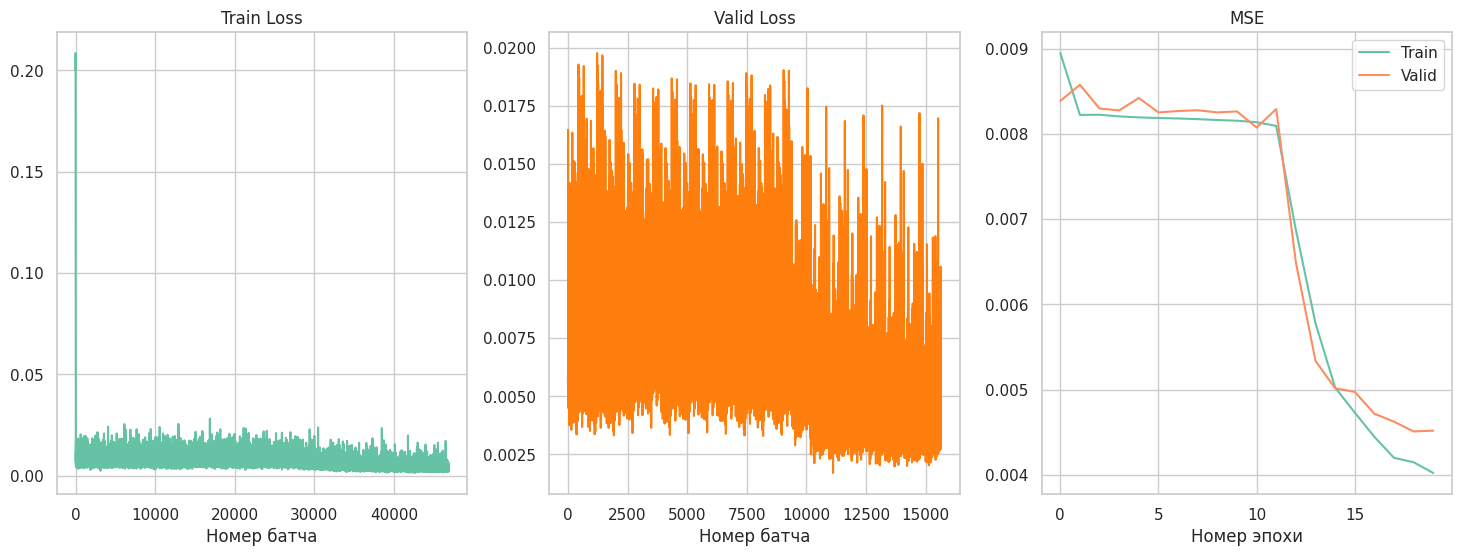

Номер эпохи: 20 | Время обучения эпохи: 0m 57s


In [ ]:
training_loop(model3, n_epochs=20)

In [ ]:
warnings.filterwarnings('ignore')

print('MSE: ', evaluate(model3, valid_loader, criterion)[0])

MSE:  0.00451734121722143


В целом, значение MSE в этой модели на 20й эпохе получается не сильно меньше, чем у предыдущей модели. Теперь поэкспериментируем с параметром rnn_num_units.

###4ая Модель

In [ ]:
model4 = SimpleRNNRegressor(
    num_tokens=len(vocab),
    emb_size=256,
    rnn_num_units=16,
    output_dim=1,
    layers=8
).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model4.parameters(), lr=0.005)
history = []

model4

SimpleRNNRegressor(
  (emb): Embedding(25002, 256, padding_idx=25001)
  (rnn): LSTM(256, 16, num_layers=8, batch_first=True)
  (classifier): Linear(in_features=16, out_features=1, bias=True)
)

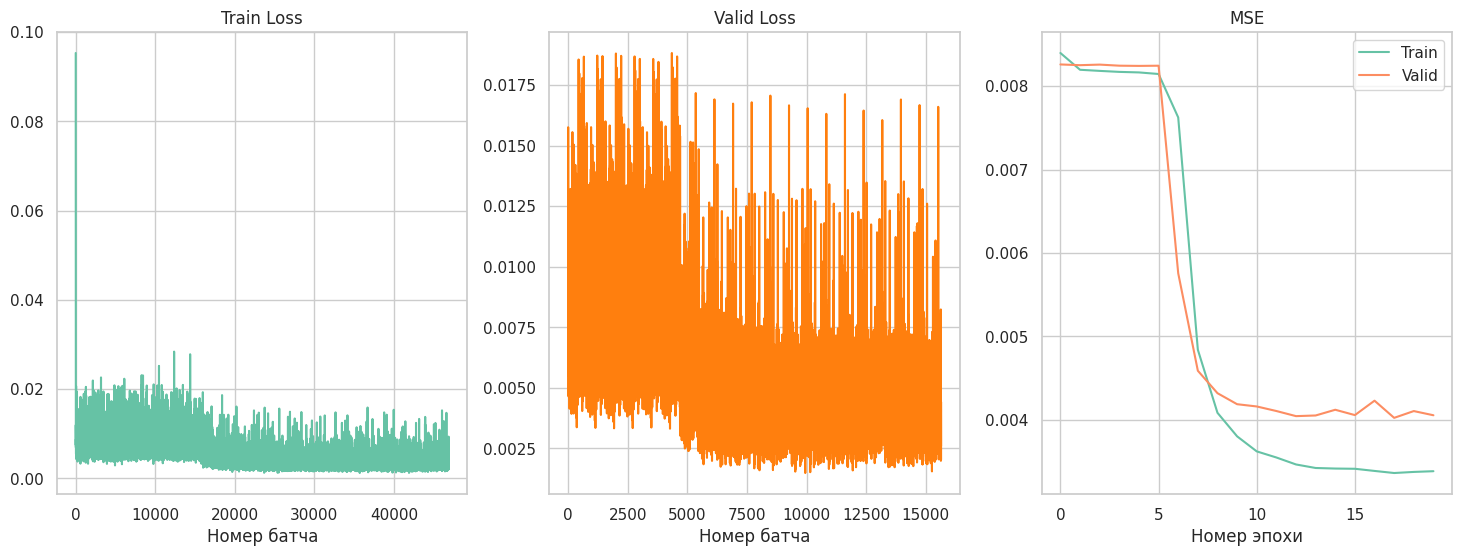

Номер эпохи: 20 | Время обучения эпохи: 1m 0s


In [ ]:
training_loop(model4, n_epochs=20)

In [ ]:
warnings.filterwarnings('ignore')

print('MSE: ', evaluate(model4, valid_loader, criterion)[0])

MSE:  0.004056007861394359


При увеличении rnn_num_units до 16 с тем же значением layers, MSE начал значительно уменьшаться после 5ой эпохи, а в предыдущей модели при таком же значении layers только после 11. Также значение MSE на валидационной части на последней эпохе меньше, чем у предыдущих моделей.

###5я Модель

In [ ]:
model5 = SimpleRNNRegressor(
    num_tokens=len(vocab),
    emb_size=256,
    rnn_num_units=4,
    output_dim=1,
    layers=8
).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model5.parameters(), lr=0.005)
history = []

model5

SimpleRNNRegressor(
  (emb): Embedding(25002, 256, padding_idx=25001)
  (rnn): LSTM(256, 4, num_layers=8, batch_first=True)
  (classifier): Linear(in_features=4, out_features=1, bias=True)
)

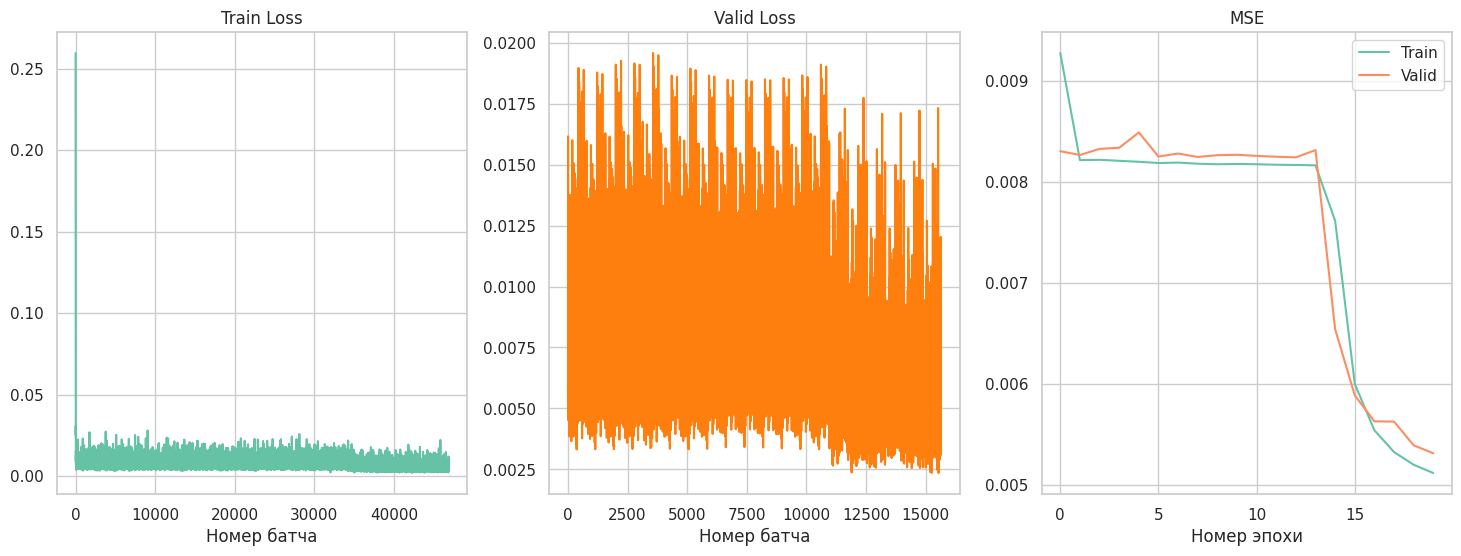

Номер эпохи: 20 | Время обучения эпохи: 1m 2s


In [ ]:
training_loop(model5, n_epochs=20)

In [ ]:
warnings.filterwarnings('ignore')

print('MSE: ', evaluate(model5, valid_loader, criterion)[0])

MSE:  0.0053133193485062485


При уменьшении rnn_num_units до 4 MSE сразу возрастает, т.е. точность падает. При этом обучение заметно опять достаточно поздно(только после 13 эпохи).

###6ая Модель

In [ ]:
model6 = SimpleRNNRegressor(
    num_tokens=len(vocab),
    emb_size=128,
    rnn_num_units=16,
    output_dim=1,
    layers=8
).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model6.parameters(), lr=0.005)
history = []

model6

SimpleRNNRegressor(
  (emb): Embedding(25002, 128, padding_idx=25001)
  (rnn): LSTM(128, 16, num_layers=8, batch_first=True)
  (classifier): Linear(in_features=16, out_features=1, bias=True)
)

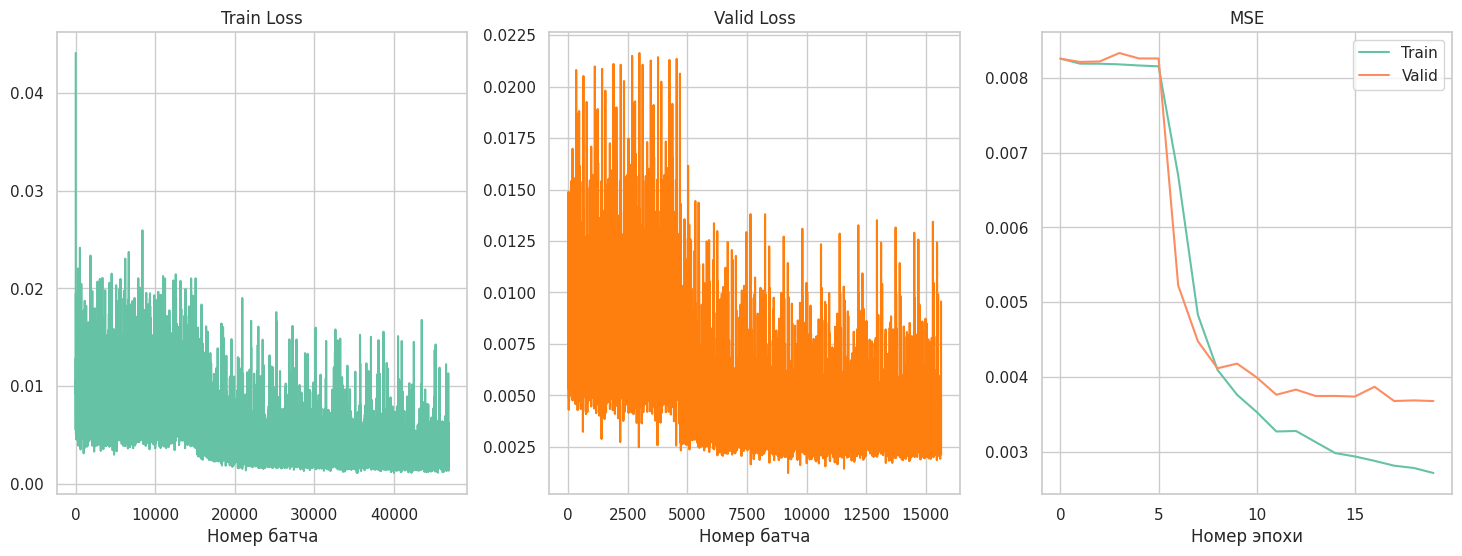

Номер эпохи: 20 | Время обучения эпохи: 0m 55s


In [ ]:
training_loop(model6, n_epochs=20)

In [ ]:
warnings.filterwarnings('ignore')

print('MSE: ', evaluate(model6, valid_loader, criterion)[0])

MSE:  0.003674945560024332


Заметим, что точность силно увеличилась(так как MSE уменьшился). То есть для увеличения точности в данной задаче нужно брать размер эмбеддингового пространства не очень большой(вначале взяв 256 мы, получается, не угадали). Так как нас не просили выбивать лучшее качество, то остановимся на этом.

Выведите несколько примеров работы на тестовой выборке: текст вакансии, предсказание вашей модели и истинное значение зарплаты. Чтобы вернуть все значения к изначальным масштабам, используйте `scaler.inverse_transform(...)`. Также посчитайте MSE на всей тестовой выборке.

Выберем оптимальную модель(6ю модель):

In [ ]:
model = SimpleRNNRegressor(
    num_tokens=len(vocab),
    emb_size=128,
    rnn_num_units=16,
    output_dim=1,
    layers=8
).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
history = []

model

SimpleRNNRegressor(
  (emb): Embedding(25002, 128, padding_idx=25001)
  (rnn): LSTM(128, 16, num_layers=8, batch_first=True)
  (classifier): Linear(in_features=16, out_features=1, bias=True)
)

In [ ]:
model.load_state_dict(torch.load('model_checkpoint.pt'))

<All keys matched successfully>

In [ ]:
idxs = np.random.choice(len(dataset), 8, replace=False)
with torch.no_grad():
    for i, idx in enumerate(idxs, start=1):
        text, target = dataset.iloc[idx]
        tokens = vocab(tokenizer(text))
        tokens = torch.LongTensor(tokens).to(device)
        output = model(tokens).squeeze(1).cpu()[-1].reshape(1, -1)
        print("=" * 20)
        print("Text:")
        print(text[0:300])
        print(f"Predicted label: {int(scaler.inverse_transform(output).item())}")
        print(f"True label: {target}")

Text:
Precedo Healthcare is currently seeking enthusiastic Hospital Healthcare Assistants to work as Band 2 Healthcare Assistants to join our ever expanding team, to work in various hospital trusts in Nottinghamshire and the surrounding area. Locations include: Gamston and Sutton in Ashfield You will be w
Predicted label: 16426
True label: 21513
Text:
Software Support Primavera Project Planner Manchester ****k New  Project Planner required for dynamic software house near Cheadle. You'll be working alongside the Programme Managers to ensure product development plans are fully integrated with customer implementation plans. Projects are delivered on
Predicted label: 40166
True label: 35000
Text:
I am working with a leading accountancy practice in their Birmingham office who are looking for a driven ShareSchemes Manager to join this growing and market leading team. You'll gain a broad and varied exposure to the ShareSchemes function with a diverse and high level client portfolio. You'll be

Также выведем еще раз MSE:

In [ ]:
warnings.filterwarnings('ignore')

print('MSE: ', evaluate(model, valid_loader, criterion)[0])

MSE:  0.003674945560024332


**Вывод:**
1) Используя рекурентные нейронные сети, мы смогли с неплохой точностью предсказывать зарплаты по описаниям вакансий. Причем MSE, а значит и точноть предсказаний, зависит от параметров класса SimpleRNNRegressor.\
2) Также заметим, что на время, которое занимает одна эпоха, сильно влияет кол-во слоев в RNN(layers) и чуть слабее размер эмбеддингового пространства(emb_size).\
3) Изменение размера пространства скрытых представлений в rnn(rnn_num_units) не влияет на обучаемость модели(в отличие от layers). Но при этом, точность предсказаний возрастает с увеличением значения параметра rnn_num_units.\
4) Изменение кол-ва слоев в RNN(layers) влияет на обучаемость модели. Так при layers = 1 график MSE вырождается в константу, и модель не обучается. При этом, при больших значениях параметра модель обучается. Также заметно, что при увеличении layers MSE становится меньше, т.е. точночть предсказаний растет.\
5) Также при уменьшении параметра emb_size(размер эмбеддингового пространства) точность предсказаний растет.

---
### Задача 2. Использование большой языковой модели


Ваша задача &mdash; применить <a target="_blank" href="https://llama-2.ai/">Llama 2</a> к предыдущей задаче и заставить ее предсказать заработную плату по текстовому описанию. Существует мало русскоязычных моделей, способных решить такую задачу и помещающихся в <a target="_blank" href="https://colab.research.google.com/">Colab</a>, поэтому вам придется писать запросы на английском!

In [2]:
!pip install bitsandbytes==0.41.1 transformers==4.34.1 accelerate==0.24.0 sentencepiece==0.1.99 optimum==1.13.2 auto-gptq==0.4.2  > null
import transformers
import bitsandbytes as bnb

assert torch.cuda.is_available(), "для этой части понадобится GPU"

Дисклеймер: *использовать LLM в рамках ограничений Colab хоть и возможно, но очень трудно.*

> Так как процесс генерации очень хрупкий и может сломаться при любом неверном движении, мы настоятельно рекомендуем **сохранить результаты предыдущего задания в отдельном файле** и приступать к этой задаче в самом конце. Решения задач можно сдавать в бот разными файлами.

> Если у вас возникла ошибка `Out of memory`, перезапустите ноутбук и попробуйте снова. Да, языковые модели без своей GPU &mdash; это тяжело...





От вас требуется подобрать такой промпт, который приводил бы к нужному выводу модели. Можете экспериментировать с параметрами генерации, список которых можно посмотреть в <a target="_blank" href="https://github.com/huggingface/transformers/blob/c4d4e8bdbd25d9463d41de6398940329c89b7fb6/src/transformers/generation_utils.py#L101">исходнике</a>.

Существуют различные техники, которые могут помочь вам "разговорить" языковую модель. О многих из них вы сможете прочитать <a target="_blank" href="https://docs.mistral.ai/guides/prompting-capabilities/">здесь</a>. В нашем случае полезным может быть метод Few-Shot Learning, который заключается в предоставлении модели нескольких примеров.

In [3]:
model_name = "TheBloke/Llama-2-13B-GPTQ"

# Загружаем Llama токенизатор
tokenizer = transformers.LlamaTokenizer.from_pretrained(
    model_name, device_map=device
)
tokenizer.pad_token_id = tokenizer.eos_token_id

# И саму модель Llama
model = transformers.AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map="auto",
    torch_dtype=torch.float16,
    low_cpu_mem_usage=True,
    offload_state_dict=True,
)

You are using the default legacy behaviour of the <class 'transformers.models.llama.tokenization_llama.LlamaTokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thouroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:311: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:311: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


Используем метод Few-Shot Learning, который заключается в предоставлении модели нескольких примеров. Для этого выберем рандомные примеры из датасета из первого задания и выведем их:

In [14]:
import random

indexes = np.arange(len(dataset)).tolist()

for i in range(4):
    idx = random.choice(indexes)
    print("=" * 20)
    print("Text:")
    print(dataset.iloc[idx]["FullDescription"])
    print("Salary: ", dataset.iloc[idx]["SalaryNormalized"])

Text:
Temporary work available through Jark Construction Recruitment Agency. Reliable labourer required for a well known Sub Contractor who hold a very healthy order book for ****013, meaning this contract will lead to further opportunities for the right person. CSCS/CPCS and PPE required, along with 2 reference contacts and ID; Passport/BirthCert, Driving License/Utilty Bill, and proof of National Insurance Number. At Jark we work with many of the Main Contractors in the industry, as well as a large volume of SubContract Companies, we have new orders placed everyday. Please contact the Jark team on **** **** or email the documents above to ruterjark.co.uk Skills Required  CSCS
Salary:  15360
Text:
Role and ResponsibilitiesDownloading and updating reports saved on ftp driveUpdate Purchase Ledger spreadsheetsDaily reconciling of postings Fortnightly bank reconciliationRaising Invoices sale of caravans searches lease secondary rental  TOGMonitor and credit control of invoicesMonitor/reco

Теперь выведем тестовый запрос и ответ:

In [15]:
idx = random.choice(indexes)
print("Text:")
print(dataset.iloc[idx]["FullDescription"])
print("Salary: ", dataset.iloc[idx]["SalaryNormalized"])

Text:
Are you an experienced Customer Services Advisor looking for a permanent role in North Tyneside? If so, read on Adecco is working together with a well know Building Society to recruit experienced Customer Services Advisors. Working between the hours of ****  **** 5 days out of 7, you will provide an excellent services on an inbound basis. As well as providing a customer service, you will be expected to ask the customer about a variety of products to up sell and generate leads for Mortgages, Loans, Insurance etc. As you will be working for a financial institution, you will be expected to pass a rigid credit check, so if you have any adverse credit history, please do not apply as you will not pass. Adecco is an equal opportunities employerAdecco is acting as an Employment Agency in relation to this vacancy. This job was originally posted as www.totaljobs.com/JobSeeking/CustomerServicesAdvisor_job****
Salary:  12500


In [17]:
import warnings
warnings.filterwarnings('ignore')

prompt = """Your task is to predict the employee’s salary based on the job description.

Examples:
====================
Text:
Temporary work available through Jark Construction Recruitment Agency. Reliable labourer required for a well known Sub Contractor who hold a very healthy order book for ****013, meaning this contract will lead to further opportunities for the right person. CSCS/CPCS and PPE required, along with 2 reference contacts and ID; Passport/BirthCert, Driving License/Utilty Bill, and proof of National Insurance Number. At Jark we work with many of the Main Contractors in the industry, as well as a large volume of SubContract Companies, we have new orders placed everyday. Please contact the Jark team on **** **** or email the documents above to ruterjark.co.uk Skills Required  CSCS
Salary:  15360
====================
Text:
Role and ResponsibilitiesDownloading and updating reports saved on ftp driveUpdate Purchase Ledger spreadsheetsDaily reconciling of postings Fortnightly bank reconciliationRaising Invoices sale of caravans searches lease secondary rental  TOGMonitor and credit control of invoicesMonitor/reconcile customer/suppliers sage activityProducing Lease Vat StatementsVT rescheduling of agreementsMonitor Lease Agreements and liaise with CC ManagerReconcile lease journal movementsUpdate and monitor secondary rental receiptsSage postingsPost and reconcile dealer commissionsMonitor and amend incorrect agreements statusDownload and action monthly frozen revenue reportGeneral filingCover telephone QualificationsAAT qualification Level 2 desirableNVQ Business and Administration Level 2  desirable Preferred SkillsAccuracy and attention to detail  essentialMust be numerate essentialExcellent timekeeping  essentialHave the ability to work independently and as a part of a team essentialSome knowledge of excel/sage desired Travel RequiredMust be able to drive/have car
Salary:  13250
====================
Text:
Job Title: Night Concierge Employer Type: Hotel Annual Salary: ******** per annum Location: London About the Night Concierge Role We are currently recruiting for a Night Concierge to join the team at our stunning Soho Hotel. This position offers a rare opportunity to join a market leading hotel group best known for its exceptional standards, stylish interiors and inspirational approach to guest service. Working closely with the Night Manager this role encompasses a variety of tasks including; greeting guests to the hotel examples of these are Train the Trainer, Leadership, Learning Academies and much more. Firmdale is a Company you will be proud to work for. We are individual, stylish, modern and elegant. In recognition of our commitment to investing in our people we have won the following awards; Winner Springboard Award for Excellence  Best career progression **** Winner Training Journal Best customer service initiative **** Winner Springboard Award for Excellence  Best initiative to attract people into management **** Company Info Firmdale Hotels is an award winning hotel group. We have won the Queens Award for Excellence twice and most recently the Soho Hotel has won The Cateys Award for Hotel of the Year. Quality is what we are all about at Firmdale and that s from our individually designed bedrooms containing original pieces of artwork to the Egyptian cotton linen used in the restaurant. We believe that the customer truly comes first and that if we get the minor detail right then everything else will follow. Our culture suits down to earth, genuinely friendly, ambitious and hardworking people. If you want to be noticed and recognized for your individual contribution then this is the company for you. As a result of our success we are a rapidly expanding group and therefore are able to offer excellent career progression along with individually tailor made career development plans. The behaviours we value at Firmdale are; Positive can do attitude, Enthusiastic and passionate, Consistently professional, Friendly and Attentive, Interested and Driven and Genuine/Loyal/Honest The behaviours our managers will demonstrate are; Genuine care for their people, Customer focused, Involve people and Empower, Show consistent appreciation, Show real trust, Listen and Act, Give clear expectations, Encourage teamwork, Driven/Passionate and Ensure work is fun Benefits for working for Firmdale; Extensive training and development opportunities, Career planning and progression. Competitive salaries Free Dry Cleaning for uniforms and discounted dry cleaning for employees personal items Meals on duty Incremental Holiday starting at **** and going up a day each year to 25 days. Experience Vouchers (which are redeemable during your employment) Incentive Schemes; Departmental Incentive Schemes
Salary:  15750
====================
Text:
Reporting in to the Human Resources Director you will be responsible for the design and implementation of the Compensation and Benefits strategy You will ensure the compensation and benefits strategy enables the organisation to attract and retain high calibre staff at all levels through annual benchmarking, effective internal marketing, coaching HR Business Partners, presenting to the Exco and liaising closely with colleagues in the United States. You should be of graduate calibre with a proven track record in Compensation and Benefits. Experience of producing clear and commercial MI needs be combined with an ability to build effective relationships in a matrix organisation. Our client is a market leading organisation. Please include current salary details  basic, bonus plus any benefits  when applying This job was originally posted as www.totaljobs.com/JobSeeking/HeadofCompensationandBenefits_job****
Salary:  70000
====================

Predict:

====================
Text:
Are you an experienced Customer Services Advisor looking for a permanent role in North Tyneside? If so, read on Adecco is working together with a well know Building Society to recruit experienced Customer Services Advisors. Working between the hours of ****  **** 5 days out of 7, you will provide an excellent services on an inbound basis. As well as providing a customer service, you will be expected to ask the customer about a variety of products to up sell and generate leads for Mortgages, Loans, Insurance etc. As you will be working for a financial institution, you will be expected to pass a rigid credit check, so if you have any adverse credit history, please do not apply as you will not pass. Adecco is an equal opportunities employerAdecco is acting as an Employment Agency in relation to this vacancy. This job was originally posted as www.totaljobs.com/JobSeeking/CustomerServicesAdvisor_job****


"""
batch = tokenizer(prompt, return_tensors='pt', return_token_type_ids=False).to(device)

output_tokens = model.generate(**batch, max_new_tokens=64, do_sample=True, temperature=0.8)

print("\nOutput:", tokenizer.decode(output_tokens[0].cpu()))

print("Input batch (encoded):", batch)


Output: <s>Your task is to predict the employee’s salary based on the job description.

Examples:
Text:
Temporary work available through Jark Construction Recruitment Agency. Reliable labourer required for a well known Sub Contractor who hold a very healthy order book for ****013, meaning this contract will lead to further opportunities for the right person. CSCS/CPCS and PPE required, along with 2 reference contacts and ID; Passport/BirthCert, Driving License/Utilty Bill, and proof of National Insurance Number. At Jark we work with many of the Main Contractors in the industry, as well as a large volume of SubContract Companies, we have new orders placed everyday. Please contact the Jark team on **** **** or email the documents above to ruterjark.co.uk Skills Required  CSCS
Salary:  15360
Text:
Role and ResponsibilitiesDownloading and updating reports saved on ftp driveUpdate Purchase Ledger spreadsheetsDaily reconciling of postings Fortnightly bank reconciliationRaising Invoices sale

Предсказания модели и правильный ответ(см вывод модели):

***Text***:
[Текст ссылки](https://)
Are you an experienced Customer Services Advisor looking for a permanent role in North Tyneside? If so, read on Adecco is working together with a well know Building Society to recruit experienced Customer Services Advisors. Working between the hours of ****  **** 5 days out of 7, you will provide an excellent services on an inbound basis. As well as providing a customer service, you will be expected to ask the customer about a variety of products to up sell and generate leads for Mortgages, Loans, Insurance etc. As you will be working for a financial institution, you will be expected to pass a rigid credit check, so if you have any adverse credit history, please do not apply as you will not pass. Adecco is an equal opportunities employerAdecco is acting as an Employment Agency in relation to this vacancy. This job was originally posted as www.totaljobs.com/JobSeeking/CustomerServicesAdvisor_job****


***Predicted:*** 15360

***Correct Salary***: 12500

Если почувствуете, что у вас не получается добиться от модели желаемого, вы можете попробовать воспользоваться любой другой языковой моделью на ваш выбор, но тогда вы получите **не больше 30 баллов**.

В случае использования другой модели предоставьте скриншот ответа LLM и промпт, который вы использовали (в текстовом формате). Его можно вставить прямо в ноутбук или прислать в бот отдельным файлом.

**Вывод:**
1) С помощью этой LLM мы смогли получить предсказание зарплаты по промту, но это было очень нетривиально...\
2) Без правильно написанного промта модель не предсказывает числовое значение. Поэтому при работе с такими моделями необходимо четко формулировать вопрос и использовать различные техники, чтобы "разговорить" модель. Очень помог метод Few-Shot Learning, который предлагался в ноутбуке \
3) Так как в модель неудобно закидывать слишком большой промт(и в целом закинуть весь датасет, вероятно, не получится из-за небольшого размера Content Length = 4k(я смотрел здесь табличку https://huggingface.co/TheBloke/Llama-2-13B-GGML)), то предсказания получаются не очень точные.\
4) Поэтому для выяснения зарплаты по описанию вакансии лучше использовать модель из 1ого задания

---
*Если хотите отточить навык написания промптов &mdash; **prompt-engineering** &mdash; можете попробовать сыграть в <a target="_blank" href="https://gandalf.lakera.ai/">игру</a>. В ней нужно заставить Гендальфа выдать пароль. Со временем уровни становятся все сложнее и требуют более хитрых приемов.*